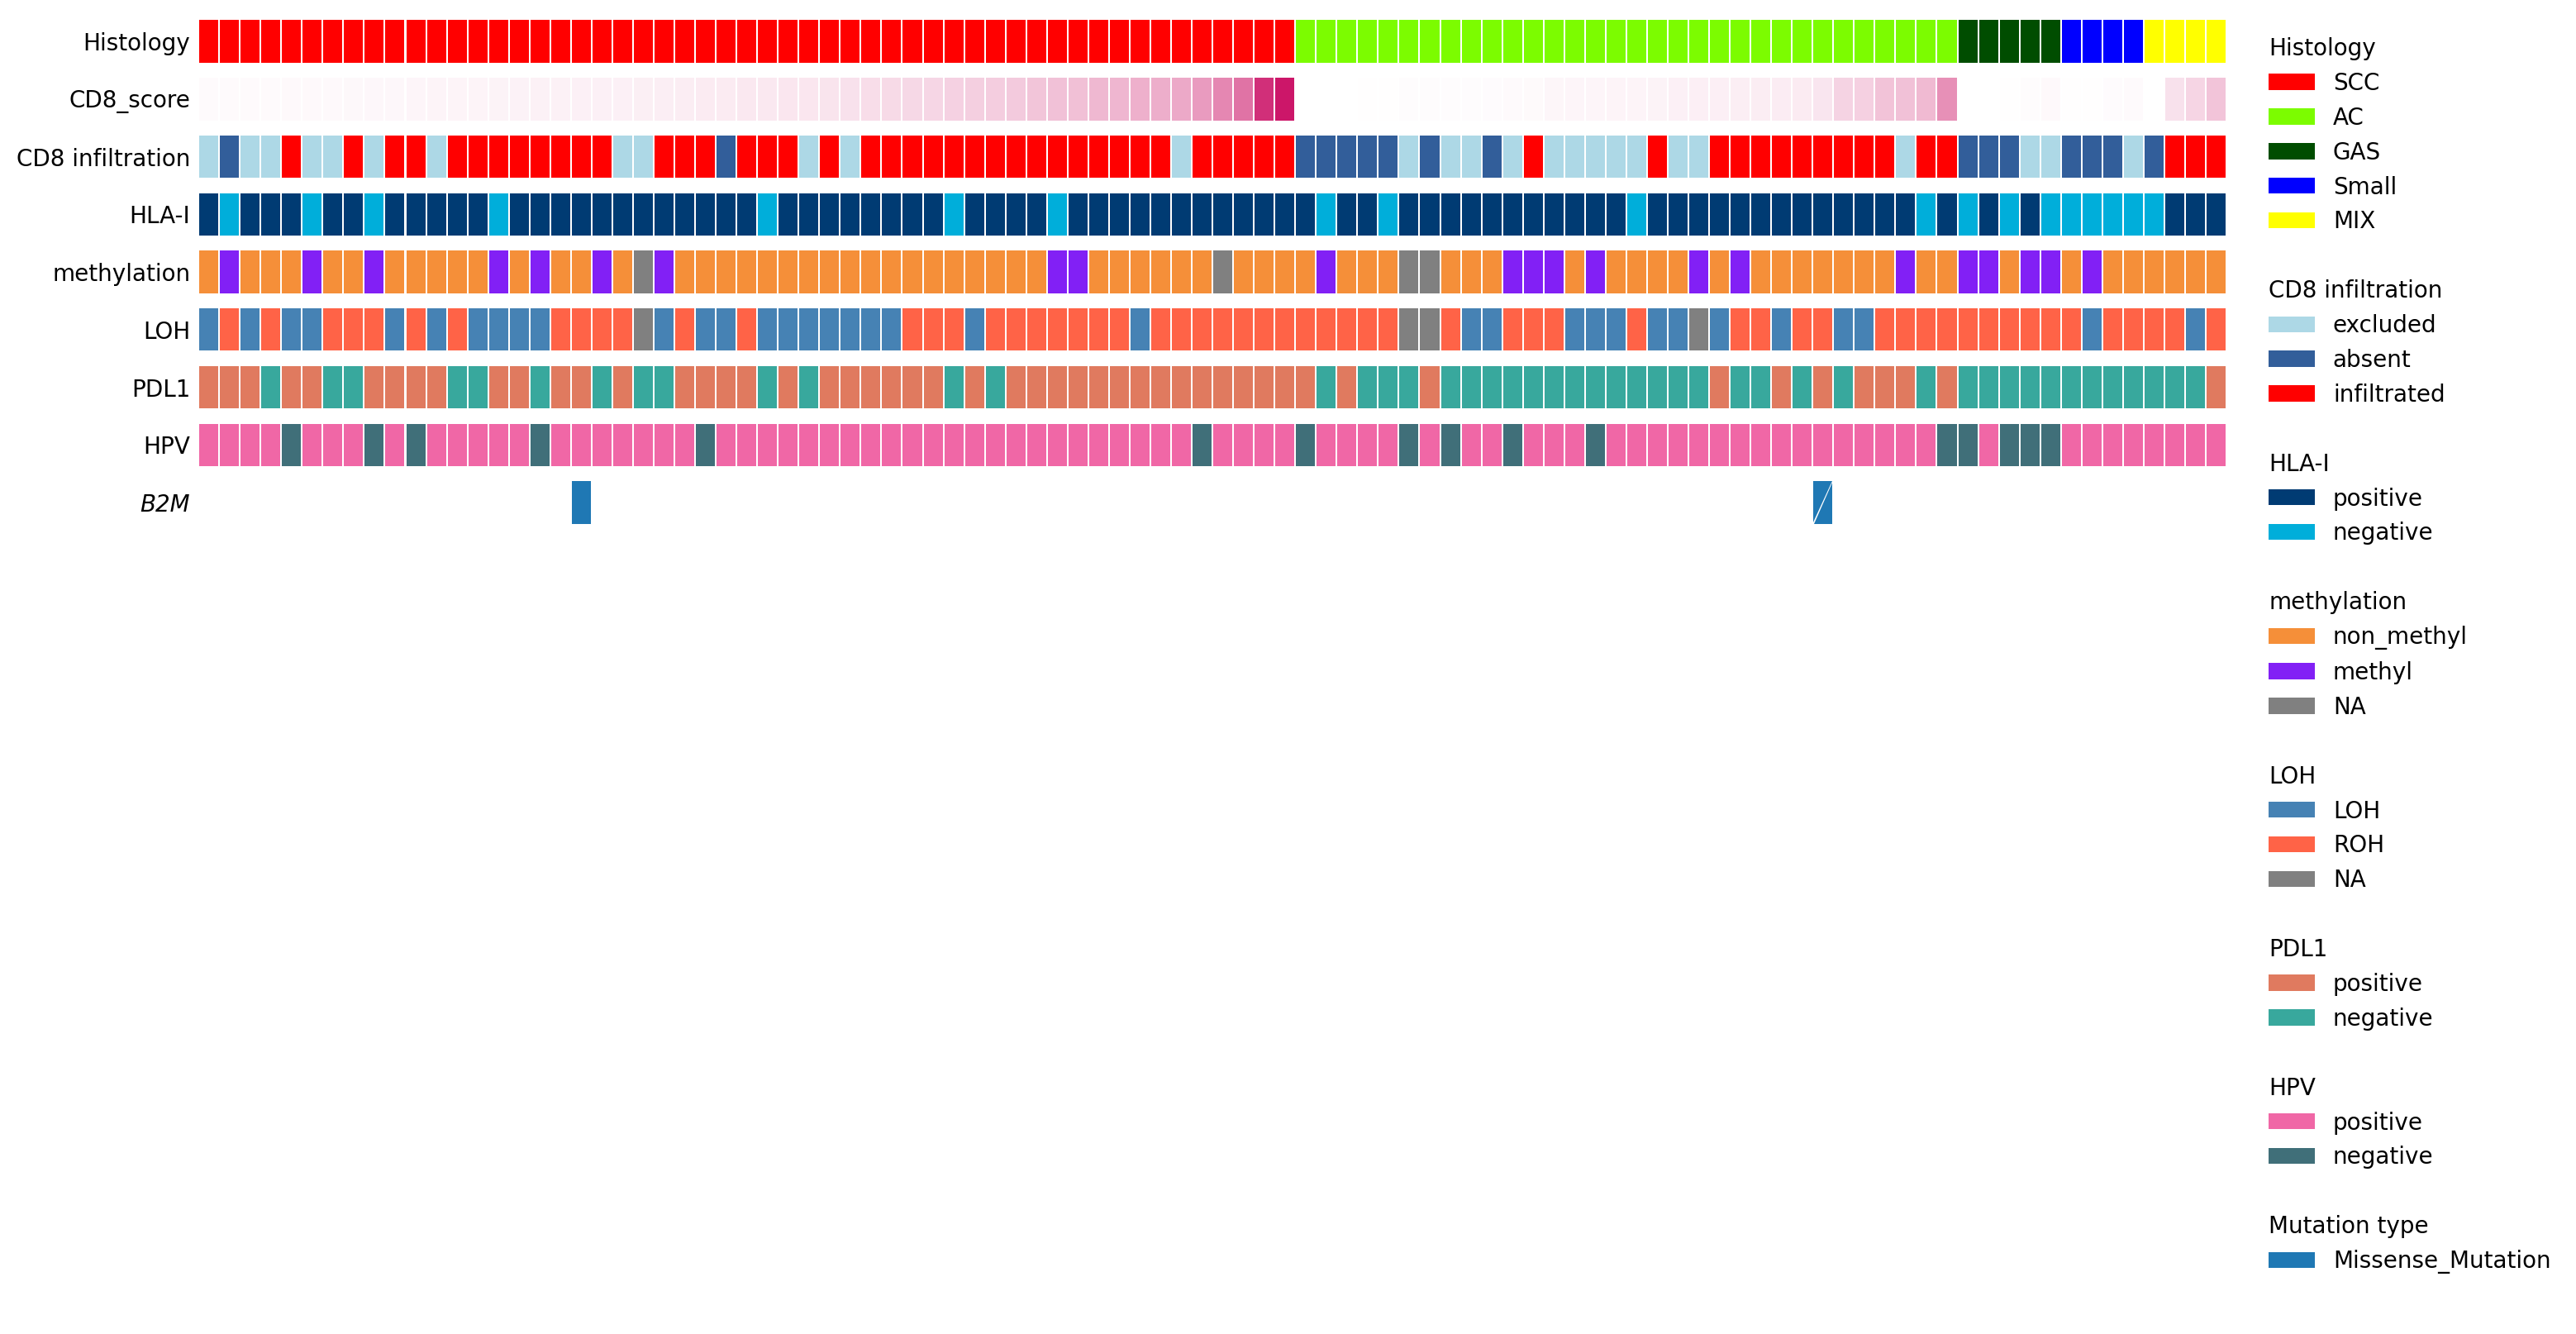

In [3]:
# ─────────────────────────────────────────────────────────────────────────────
# 0) 必要ライブラリのインストール（最初の１回だけ）
# ─────────────────────────────────────────────────────────────────────────────
!pip -q install comut palettable openpyxl

# ─────────────────────────────────────────────────────────────────────────────
# 1) Imports & Notebook 設定
# ─────────────────────────────────────────────────────────────────────────────
import warnings
warnings.filterwarnings("ignore", category=FutureWarning, module="comut\\.fileparsers")

from comut import comut, fileparsers
import pandas as pd, glob, os
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# ─────────────────────────────────────────────────────────────────────────────
# 2) ユーザー設定
# ─────────────────────────────────────────────────────────────────────────────
# MAF ファイルのパス一覧を取得
maf_paths = glob.glob('./mafs/*.maf')

# ヒートマップに表示する遺伝子リスト（下→上）
genes = ['B2M']

# プロットの見た目／保存設定
dpi       = 300
x_pad     = 0.04
y_pad     = 0.04
tri_pad   = 0.03

# Variant_Classification → 色マッピング
mut_mapping = {
    "Missense_Mutation":      "#1f78b4",
    "Nonsense_Mutation":      "#33a02c",
    "Frame_Shift_Del":        "#e31a1c",
    "Frame_Shift_Ins":        "#ff7f00",
    "Splice_Site":            "#6a3d9a",
    "In_Frame_Del":           "#b15928",
    "In_Frame_Ins":           "#e31a1c",
    "Silent":                 "#999999",
    "Nonstop_Mutation":       "#a6cee3",
    "Translation_Start_Site": "#b2df8a",
}

value_order = ['Nonsense_Mutation',
               'Frame_Shift_Ins',
               'In_Frame_Ins',
              'Missense_Mutation']
priority    = ['Nonsense_Mutation',
               'Frame_Shift_Ins',
               'In_Frame_Ins',
              'Missense_Mutation']

# ─────────────────────────────────────────────────────────────────────────────
# 3) MAF を読み込み & parse_maf
# ─────────────────────────────────────────────────────────────────────────────
parsed = []
for p in maf_paths:
    df = pd.read_csv(p, sep='\t', comment='#', low_memory=False)
    parsed.append(fileparsers.parse_maf(df, rename=False))

mutation_df_all = pd.concat(parsed, ignore_index=True)
mutation_df_all['sample'] = mutation_df_all['sample'].astype(str).str.strip()

# ─────────────────────────────────────────────────────────────────────────────
# 4) HPV.csv を読み込み → サンプル順取得
# ─────────────────────────────────────────────────────────────────────────────
hpv_df = pd.read_csv('./info/HPV.csv', dtype=str)
hpv_df['value'] = hpv_df['value'].fillna('NA')
hpv_order = hpv_df['sample'].tolist()

# ─────────────────────────────────────────────────────────────────────────────
# 5) 全サンプル順序を構築
# ─────────────────────────────────────────────────────────────────────────────
all_mut_samples = mutation_df_all['sample'].unique().tolist()
remaining = [s for s in all_mut_samples if s not in hpv_order]
full_order = hpv_order + remaining

# ─────────────────────────────────────────────────────────────────────────────
# 6) CoMut インスタンス作成 & サンプル順をセット
# ─────────────────────────────────────────────────────────────────────────────
example_comut = comut.CoMut()
example_comut.samples = full_order

# ─────────────────────────────────────────────────────────────────────────────
# 7) 変異データ層を追加
# ─────────────────────────────────────────────────────────────────────────────
example_comut.add_categorical_data(
    mutation_df_all,
    name           = 'Mutation type',
    category_order = genes,
    mapping        = mut_mapping,
    value_order    = value_order,
    priority       = priority,
    tick_style     = 'italic'
)

# HPV
clin_df = pd.read_csv(
    './info/HPV.csv',
    dtype=str  # カテゴリデータを文字列で扱う
)

clin_df['value'] = clin_df['value'].fillna('NA')
hist_map = {
    'negative' : '#406F79',
    'positive': '#F067A6'
}

example_comut.add_categorical_data(clin_df, name='HPV', mapping = hist_map)

# PDL1
clin_df = pd.read_csv(
    './info/PDL1.csv',
    dtype=str  # カテゴリデータを文字列で扱う
)

clin_df['value'] = clin_df['value'].fillna('NA')
hist_map = {
    'negative' : '#38A89D',
    'positive': '#E07A5F'
}

example_comut.add_categorical_data(clin_df, name='PDL1', mapping = hist_map)

# LOH
clin_df = pd.read_csv(
    './info/LOH.csv',
    dtype=str  # カテゴリデータを文字列で扱う
)

clin_df['value'] = clin_df['value'].fillna('NA')
hist_map = {
    'LOH'   : 'steelblue',
    'ROH': 'tomato',
    'NA': 'gray'
}

example_comut.add_categorical_data(clin_df, name='LOH', mapping = hist_map)

# methylation
clin_df = pd.read_csv(
    './info/methylation.csv',
    dtype=str  # カテゴリデータを文字列で扱う
)

clin_df['value'] = clin_df['value'].fillna('NA')
hist_map = {
    'non_methyl'   : '#F58F39',
    'methyl': '#8220F5',
    'NA' : 'gray'
}

example_comut.add_categorical_data(clin_df, name='methylation', mapping = hist_map)

# HLA-I
clin_df = pd.read_csv(
    './info/HLA-I.csv',
    dtype=str  # カテゴリデータを文字列で扱う
)

hist_map = {
    'negative'   : '#00aeda',
    'positive': '#003b73',
}

example_comut.add_categorical_data(clin_df, name='HLA-I', mapping = hist_map)

# CD8_infiltration

clin_df = pd.read_csv(
    './info/CD8 infiltration.csv',
    dtype=str  # カテゴリデータを文字列で扱う
)

hist_map = {
    'absent' : '#325e9a',
    'excluded' : 'lightblue',
    'infiltrated' : 'red'
}

example_comut.add_categorical_data(clin_df, name='CD8 infiltration', mapping = hist_map)

# CD8_score
clin_df = pd.read_csv(
    './info/CD8_score.csv'
)

# ← ここを追加：白→#CC1669 のカラーマップを定義し、0–20 を正規化
cmap_cd8 = LinearSegmentedColormap.from_list(
    'white_to_deeprose',
    ['white', '#CC1669']
)

# ─────────────────────────────────────────────────────────────────────────────
# add_continuous_data に vmin=0, vmax=20 を渡す
# ─────────────────────────────────────────────────────────────────────────────
example_comut.add_continuous_data(
    clin_df,
    name   = 'CD8_score',   # DataFrame の該当カラム名と一致させる
    mapping= cmap_cd8
)

# Histology

clin_df = pd.read_csv(
    './info/Histology.csv',
    dtype=str  # カテゴリデータを文字列で扱う
)

hist_map = {
    'AC'   : '#7CFC00',
    'Small': 'blue',
    'SCC'  : 'red',
    'GAS'  : '#004D00',
    'MIX'  : 'yellow',
}

example_comut.add_categorical_data(clin_df, name = 'Histology', mapping = hist_map)
fig = example_comut.plot_comut(
    x_padding   = x_pad,
    y_padding   = y_pad,
    tri_padding = tri_pad,
    figsize     = (16, 4)
)
example_comut.add_unified_legend()
plt.xticks([])

# (d) 保存
plt.savefig('./plots/comut3.pdf', dpi=dpi, bbox_inches='tight')